<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/vae_compare_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare various VAEs side-by-side on CelebA (GSOC 2021)

Author: [Ang Ming Liang](https://github.com/Neoanarika).
Mentor: [Kevin Murphy](https://www.cs.ubc.ca/~murphyk/).

This notebook uses pre-trained models (checkpoints) that are stored in githib/ GCS.
For details on how these were created, see 
https://github.com/probml/pyprobml/tree/master/vae







# Setup

In [1]:


%%capture
!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/vae .
!pip install -qq pytorch-lightning einops

!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/download_celeba.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/two_stage_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/hinge_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/info_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/logcosh_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/mmd_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vanilla_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/sigma_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/beta_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vanilla_ae_celeba_conv.ckpt

In [2]:
!ls

assembler.py		      models
assets			      pixel_cnn_celeba_conv.ckpt
beta_vae_celeba_conv.ckpt     README.md
configs			      run_pixel.py
data.py			      run.py
download_celeba.py	      sample_data
experiment.py		      sigma_vae_celeba_conv.ckpt
flax			      standalone
hinge_vae_celeba_conv.ckpt    two_stage_vae_celeba_conv.ckpt
info_vae_celeba_conv.ckpt     utils
__init__.py		      vanilla_ae_celeba_conv.ckpt
kpmtest.py		      vanilla_vae_celeba_conv.ckpt
logcosh_vae_celeba_conv.ckpt  vq_vae_celeba_conv.ckpt
mmd_vae_celeba_conv.ckpt


In [3]:
# Load libraries needed by
# https://github.com/probml/pyprobml/blob/master/scripts/download_celeba.py

#!pip install -qq superimport
!pip install -qq absl-py

**Warning**: If you are running this on your local machine please follow the readme instructions to first download the subdirectory before using this notebook, instead of running the "setup for colab" file.

In [4]:


try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
import warnings
import matplotlib.pyplot as plt
try:
    import torchvision.transforms as transforms
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision.transforms as transforms
try:
    from download_celeba import celeba_dataloader
except ModuleNotFoundError:
    %pip install -qq download_celeba
    from download_celeba import celeba_dataloader
try:
    from assembler import get_config, assembler
except ModuleNotFoundError:
    %pip install -qq assembler
    from assembler import get_config, assembler
try:
    from utils.plot import plot_reconstruction, plot_samples
except ModuleNotFoundError:
    %pip install -qq utils
    from utils.plot import plot_reconstruction, plot_samples
from utils.interpolation import vector_of_interest, get_imrange

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_model(model_name, use_gpu=False):
  fname = f"./configs/{model_name}.yaml"
  config = get_config(fname)
  vae = assembler(config, "inference")
  if use_gpu: vae = vae.to("cuda")
  return vae

def make_and_load_models(model_names: list, use_gpu=False):
  vaes = []
  for model_name in model_names:
    vae = make_model(model_name, use_gpu)
    vae.load_model()
    vaes.append(vae)
  return vaes 

# Download data and load data module

### Get kagggle.json file so you can access the dataset
Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab using the follow script.


In [10]:
try:
    from google.colab import files
except ModuleNotFoundError:
    %pip install -qq google
    from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os

# if not os.path.exists('/root.kaggle'):
!mkdir /root/.kaggle

In [11]:

!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [12]:
# Download celeba and load datamodule 
!python download_celeba.py

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

dm = celeba_dataloader(bs, IMAGE_SIZE, CROP, DATA_PATH)



100% 1.32G/1.33G [00:10<00:00, 184MB/s]
100% 1.33G/1.33G [00:10<00:00, 140MB/s]
  0% 0.00/2.02M [00:00<?, ?B/s]
100% 2.02M/2.02M [00:00<00:00, 194MB/s]
  0% 0.00/1.54M [00:00<?, ?B/s]
100% 1.54M/1.54M [00:00<00:00, 274MB/s]
  0% 0.00/466k [00:00<?, ?B/s]
100% 466k/466k [00:00<00:00, 256MB/s]
  0% 0.00/2.07M [00:00<?, ?B/s]
100% 2.07M/2.07M [00:00<00:00, 235MB/s]
Done!
I1228 01:27:50.859333 140631168378752 utils.py:145] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I1228 01:27:50.859508 140631168378752 utils.py:157] NumExpr defaulting to 8 threads.
/content/data.py:74: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor')

In [13]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    %pip install -qq pytorch_lightning
    import pytorch_lightning as pl
pl.seed_everything(99)
dm.setup()  # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch

Global seed set to 99


Files exist already


# Comparing results

In [14]:
!mkdir figures
figdir = "figures"

In [15]:
models_to_compare = [
    "vanilla_ae",
    "vanilla_vae",
    "beta_vae",
    "info_vae",
    "hinge_vae",
    "mmd_vae",
    "logcosh_vae",
    "two_stage_vae",
    "sigma_vae",
    "vq_vae",
]
figsize_reconstruction = (10, 30)
figsize_samples = (10, 10)

vaes = make_and_load_models(models_to_compare, use_gpu=True)

## Reconstruction

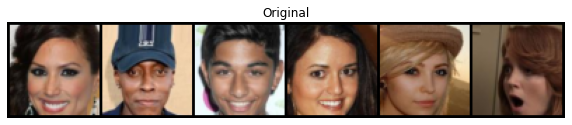

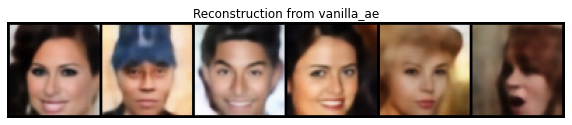

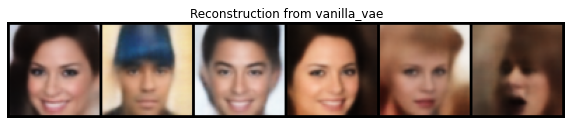

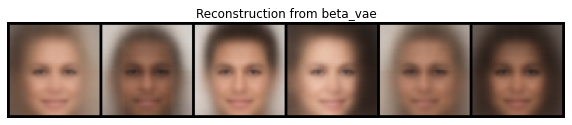

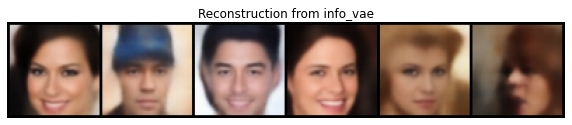

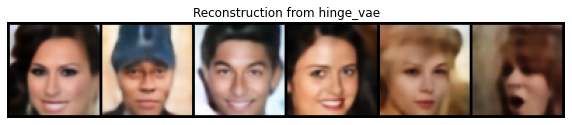

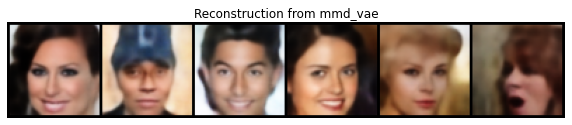

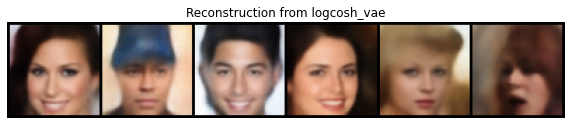

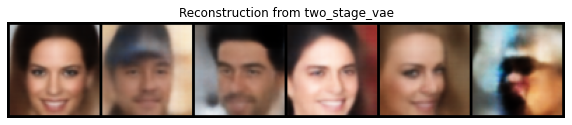

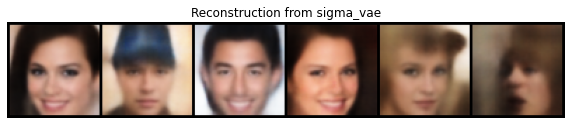

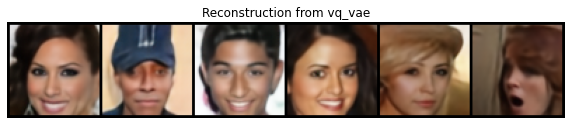

In [16]:
# deterministic given batch
num_imgs = 6
plot_reconstruction(vaes, batch, num_of_samples=num_imgs, num_of_images_per_row=num_imgs, figdir=figdir)

## Samples

Global seed set to 42


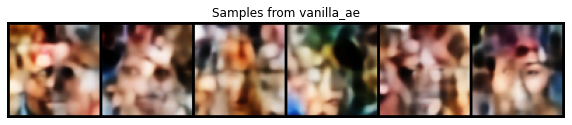

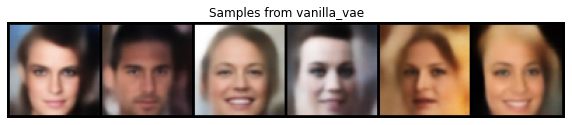

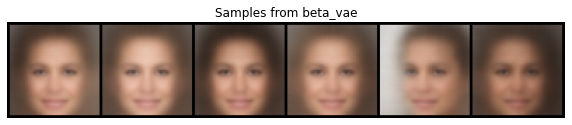

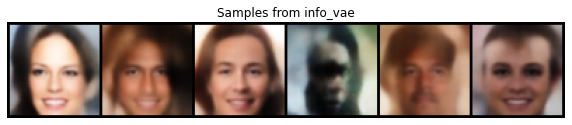

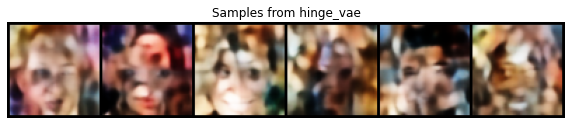

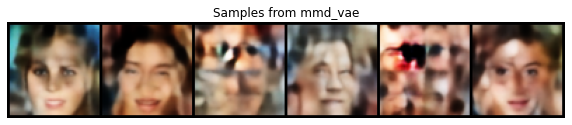

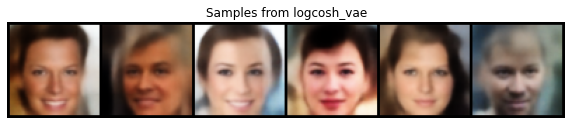

RuntimeError: ignored

In [17]:
pl.seed_everything(42)

vaes = make_and_load_models(models_to_compare, use_gpu=True)

num_imgs = 6
num_of_images_per_row = 6

plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row, figdir=figdir)

## Interpolation

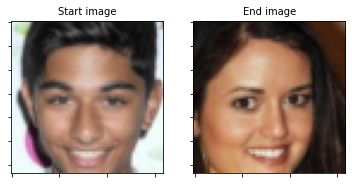

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


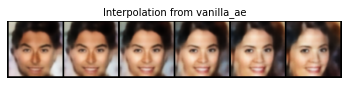

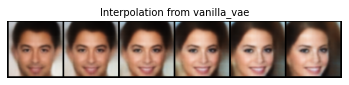

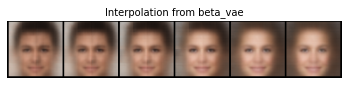

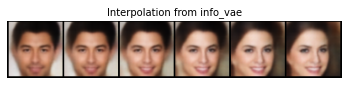

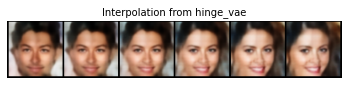

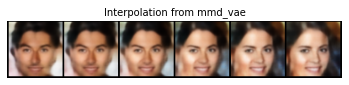

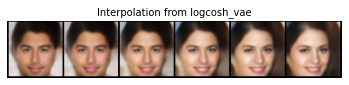

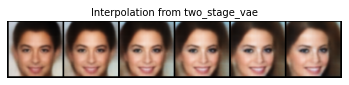

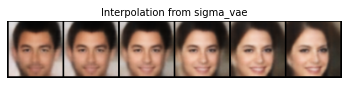

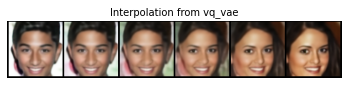

In [18]:
# deterministic given batch
try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install -qq einops
    from einops import rearrange
feature_of_interest = "Male"
vec3, male, female = vector_of_interest(vaes[0], batch, feature_of_interest)

start_img = torch.reshape(male[1], [1, 3, 64, 64])
end_img = torch.reshape(female[1], [1, 3, 64, 64])

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Start image", fontsize=10)
axs[0].imshow(rearrange(start_img, "b c h w -> h w (c b)"))
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].imshow(rearrange(end_img, "b c h w -> h w (c b)"))
axs[1].set_title("End image", fontsize=10)
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

if figdir is not None:
    filename = f"{figdir}/vae-interpolate-original.png"
    plt.savefig(filename, bbox_inches="tight")
plt.show()

for vae in vaes:
    plt.figure()  # figsize=(20,10))
    plt.title(f"Interpolation from {vae.model_name}", fontsize=10)
    arr = get_imrange(vae.decode, vae.det_encode(start_img), vae.det_encode(end_img), nums=6, interpolation="linear")
    plt.axis("off")
    plt.imshow(arr)
    if figdir is not None:
        filename = f"{figdir}/vae-interpolate-{vae.model_name}.png"
        plt.savefig(filename, bbox_inches="tight")

plt.show()

## Save figures

In [19]:
!ls figures

vae-interpolate-beta_vae.png	   vae-recon-mmd_vae.png
vae-interpolate-hinge_vae.png	   vae-recon-original.png
vae-interpolate-info_vae.png	   vae-recon-sigma_vae.png
vae-interpolate-logcosh_vae.png    vae-recon-two_stage_vae.png
vae-interpolate-mmd_vae.png	   vae-recon-vanilla_ae.png
vae-interpolate-original.png	   vae-recon-vanilla_vae.png
vae-interpolate-sigma_vae.png	   vae-recon-vq_vae.png
vae-interpolate-two_stage_vae.png  vae-samples-beta_vae.png
vae-interpolate-vanilla_ae.png	   vae-samples-hinge_vae.png
vae-interpolate-vanilla_vae.png    vae-samples-info_vae.png
vae-interpolate-vq_vae.png	   vae-samples-logcosh_vae.png
vae-recon-beta_vae.png		   vae-samples-mmd_vae.png
vae-recon-hinge_vae.png		   vae-samples-vanilla_ae.png
vae-recon-info_vae.png		   vae-samples-vanilla_vae.png
vae-recon-logcosh_vae.png


In [ ]:
!rm /content/vae-figs.zip
!zip -r /content/vae-figs.zip /content/figures

  adding: content/figures/ (stored 0%)
  adding: content/figures/vae-recon-original.png (deflated 0%)
  adding: content/figures/vae-interpolate-two_stage_vae.png (deflated 0%)
  adding: content/figures/vae-samples-vq_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-hinge_vae.png (deflated 0%)
  adding: content/figures/vae-samples-mmd_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-beta_vae.png (deflated 0%)
  adding: content/figures/vae-recon-mmd_vae.png (deflated 0%)
  adding: content/figures/vae-samples-beta_vae.png (deflated 1%)
  adding: content/figures/vae-recon-info_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-vanilla_ae.png (deflated 0%)
  adding: content/figures/vae-recon-vanilla_ae.png (deflated 0%)
  adding: content/figures/vae-interpolate-vanilla_vae.png (deflated 0%)
  adding: content/figures/vae-samples-two_stage_vae.png (deflated 0%)
  adding: content/figures/vae-recon-hinge_vae.png (deflated 0%)
  adding: content/figures/

In [ ]:
try:
    from google.colab import files
except ModuleNotFoundError:
    %pip install -qq google
    from google.colab import files
files.download("/content/vae-figs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>